In [13]:
import numpy as np
import math
import random

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import linear_model, datasets


# Plotter:---------------------------------------------------------
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
#--------------(plotter)-------------------------------------------

[[-0.92452472  0.70908964]
 [ 0.45396042 -0.5123883 ]
 [ 0.26823724 -0.42798735]
 ...
 [ 1.10444329 -1.09258293]
 [ 0.7726879   0.76402123]
 [-0.96383412  0.77216078]]
[1 0 1 ... 0 1 1]


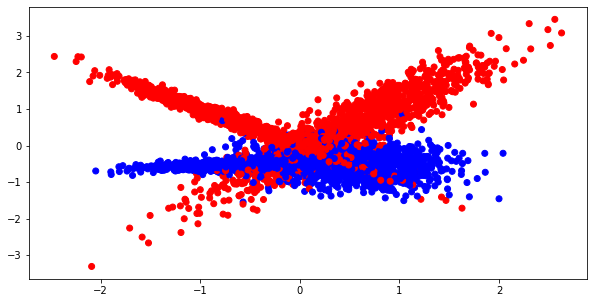

In [14]:

# Data set example:-------------------------------------------------------------------------
# n_samples int, default=100 The number of samples.
# n_features int, default=20 The total number of features. These comprise n_informative informative features, n_redundant redundant features, n_repeated duplicated features and n_features-n_informative-n_redundant-n_repeated useless features drawn at random.
# n_informative int, default=2 The number of informative features. Each class is composed of a number of gaussian clusters each located around the vertices of a hypercube in a subspace of dimension n_informative. For each cluster, informative features are drawn independently from N(0, 1) and then randomly linearly combined within each cluster in order to add covariance. The clusters are then placed on the vertices of the hypercube.
# n_redundant int, default=2 The number of redundant features. These features are generated as random linear combinations of the informative features.
# n_repeated int, default=0 The number of duplicated features, drawn randomly from the informative and the redundant features.
# n_classes int, default=2 The number of classes (or labels) of the classification problem.
# n_clusters_per_class int, default=2 The number of clusters per class.
# weights array-like of shape (n_classes,) or (n_classes - 1,), default=None The proportions of samples assigned to each class. If None, then classes are balanced. Note that if len(weights) == n_classes - 1, then the last class weight is automatically inferred. More than n_samples samples may be returned if the sum of weights exceeds 1. Note that the actual class proportions will not exactly match weights when flip_y isn’t 0.
# flip_y float, default=0.01 The fraction of samples whose class is assigned randomly. Larger values introduce noise in the labels and make the classification task harder. Note that the default setting flip_y > 0 might lead to less than n_classes in y in some cases.
# class_sep float, default=1.0 The factor multiplying the hypercube size. Larger values spread out the clusters/classes and make the classification task easier.
# hypercube bool, default=True If True, the clusters are put on the vertices of a hypercube. If False, the clusters are put on the vertices of a random polytope.
# shift float, ndarray of shape (n_features,) or None, default=0.0 Shift features by the specified value. If None, then features are shifted by a random value drawn in [-class_sep, class_sep].
# scale float, ndarray of shape (n_features,) or None, default=1.0 Multiply features by the specified value. If None, then features are scaled by a random value drawn in [1, 100]. Note that scaling happens after shifting.
# shuffle bool, default=True Shuffle the samples and the features.
# random_state int, RandomState instance or None, default=None Determines random number generation for dataset creation. Pass an int for reproducible output across multiple function calls. See Glossary.

# сгеренируем данные с помощью sklearn.datasets
X, Y = datasets.make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=3,
    class_sep=0.5
)

colors = ListedColormap(['blue', 'red'])
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=colors);

#Qv,Qp = X.shape
#(Qv,Qp)

#print (X[:, 0])
#print (X[:, 1])
print (X)
print (Y)

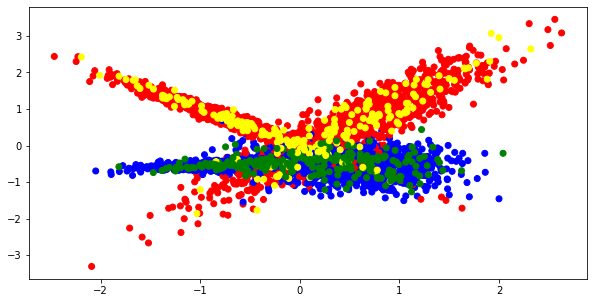

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.1,random_state=1)

colors = ListedColormap(['blue', 'red'])
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=colors);

colors = ListedColormap(['green', 'yellow'])
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=colors);

In [29]:


def max_min (any_array) : 
    max = np.amax(any_array)
    min = np.amin(any_array)
    return max,min


def split_by_value(X,threshold,target_column_index,Y):
    Qv,Qp = X.shape;
    left_x=[]; left_y=[]; right_x=[]; right_y=[];
    for j in range(0,Qv):
        if X[j][target_column_index]>=threshold :
            right_x.append(X[j]);
            right_y.append(Y[j]);
        else:
            left_x.append(X[j]);
            left_y.append(Y[j]);
    return np.array(left_x),np.array(right_x),np.array(left_y),np.array(right_y);


def sort_classes(y_vector):
    class_map = {};
    for element in y_vector:
        if element not in class_map: class_map[element] = []
        class_map[element].append(element);
    lengths = []
    for class_key in class_map: lengths.append(len(class_map[class_key]));
    return np.array(lengths);
            
    
class GiniIndex:
    
    def calculate (self,y_vector) :
        P = sort_classes(y_vector)/len(y_vector);
        xtr=0.0;
        for p_k in P: xtr+=p_k*(1-p_k);
        return xtr;

    
class ShenonIndex:
    
    def calculate (self,y_vector) :
        P = sort_classes(y_vector)/len(y_vector);
        xtr=0.0;
        for p_k in P: xtr-=p_k*self.log2(p_k);
        return xtr;
    
    def log2 (self,x_scalar):
        x=x_scalar;
        if(x_scalar==0): x=0.000000001;
        return np.log2(x);

    
class QualityCalculator:
    
    def __init__(self,index_calculator):
        self.index_calculator = index_calculator;
        
    def calculate(self,y_left,y_right,y_overall):
        overall = 1.0*len(y_overall);
        left = len(y_left);
        right = len(y_right);
        q_left = self.index_calculator.calculate(y_left);
        q_right = self.index_calculator.calculate(y_right);
        quality = self.index_calculator.calculate(y_overall) - q_left*left/overall - q_right*right/overall;
        return quality,q_left,q_right;


class Node :
    def __init__(self):
        self.prop_threshold = None;
        self.prop_index = None;
        self.left = None;
        self.right = None;
        self.values= None;
        
    def is_leaf(self) :
        return self.values is not None;
    
    def get_prediction(self,threshold_function) :
        avg = np.average(self.values);
        if threshold_function is not None:
            avg = threshold_function(avg);
        return avg;
    
    def select_right_left(self,x_vector) :
        if x_vector[self.prop_index]>=self.prop_threshold:
            return self.right;
        else:
            return self.left;

    def __str__(self):
        return "<<Node: t={},i={},left={},right={},values={}>>".format(self.prop_threshold,
                                                                   self.prop_index,self.left,self.right,self.values);
        
    
class GridElement:
    
    def __init__(self,index,threshold) :
        self.prop_index = index;
        self.prop_threshold = threshold;
        self.quality_value = 0.0;
        self.prop_left_values = [];
        self.prop_right_values = [];
        self.target_left_values = [];
        self.target_right_values = [];
        
    def __str__(self):
        return "GridElement: index={}, treshold={}, quality={}".format(self.prop_index,self.prop_threshold,self.quality_value);


# Special for the task 5:----------------------------------------------------------------------
# The special function for building randomized grid.    
def make_randomized_property_matrix(property_matrix):
    Qv,Qp = property_matrix.shape;
    
    matrix_columns = list(range(0,Qp));
    matrix_limit = int(np.round(np.sqrt(Qp)));
    matrix_limit = 1 if matrix_limit<=0 else matrix_limit;
    
    subsample = np.random.choice(matrix_columns, size=matrix_limit, replace=False);
    new_matrix = property_matrix.T[subsample]
    return new_matrix.T

#-----------------------(special for the task 5)----------------------------------------------


def make_grid_elements (grid_size,property_matrix,random_option=False):
    
    # Special for the task 5:-----------------------------------------------------------------
    #if random_option:
    #    property_matrix = make_randomized_property_matrix(property_matrix);
    #    print("Randomized={}".format(property_matrix));
    #-------------------(Special for the task 5)----------------------------------------------
        
    Qv,Qp = property_matrix.shape;
    grid_elements = [];
    for property_index in range (0,Qp):
        property_values = [];
        for vector_index in range (0,Qv): property_values.append(property_matrix[vector_index][property_index]);
        max,min = max_min(property_values);
        delta = np.abs((max-min)/grid_size);
        property_values = np.linspace(min-delta,max+delta, grid_size, endpoint=True);
        for property_value in property_values: grid_elements.append(GridElement(index=property_index,threshold=property_value));
    return grid_elements;


def calculate_grid_quality ( grid_elements, property_matrix, target_values, index_calculator ):
    quality_calculator = QualityCalculator(index_calculator);
    for grid_element in grid_elements:
        lx,rx,ly,ry=split_by_value( X=property_matrix, target_column_index=grid_element.prop_index,
                                   threshold=grid_element.prop_threshold, Y=target_values );
        q,ql,qr= quality_calculator.calculate( ly, ry, target_values );
        grid_element.quality_value = q;
        grid_element.target_left_values = ly;
        grid_element.target_right_values = ry;
        grid_element.prop_left_values = lx;
        grid_element.prop_right_values = rx;
    return grid_elements;


class RecursiveDepthCnt:
    def __init__(self):
        self.depth_map = {};
        
    def count_depth (self,prev_depth,element):
        if prev_depth not in self.depth_map:self.depth_map[prev_depth]=[];
        self.depth_map[prev_depth].append(element);
        prev_depth=prev_depth+1;
        return prev_depth;

class TreeBuildController:
    
    def __init__(self, single_class_per_leaf=True, max_depth=None, min_leaf_value_num=None):
        self.single_class_per_leaf = single_class_per_leaf;
        self.max_depth = max_depth;
        self.min_leaf_value_num = min_leaf_value_num;
        self.prop_limit = 2;
    
    def stop_splitting (self,prop_matrix,target_values,current_depth):
        control_cnt=0
        control_cnt+=self.check_prop_matrix(prop_matrix);
        
        if self.single_class_per_leaf ==True and self.check_class_per_leaf(target_values):
            control_cnt+=1;
        if (self.max_depth is not None) and self.check_max_depth(current_depth):
            control_cnt+=1;
        if (self.min_leaf_value_num is not None) and self.check_leaf_values(target_values):
            control_cnt+=1;
        if control_cnt==0: print("   --> Splitting...");
        else: print("   --> Stop split control={}".format(control_cnt));
        return control_cnt>=1;
    
    def check_prop_matrix (self,prop_matrix):
        Qv,Qp = prop_matrix.shape;
        if Qv<self.prop_limit:
            print("______hard_learn_values: {}".format(prop_matrix))
            return 1;
        else:
            return 0;
        
    def check_class_per_leaf (self,target_values):
        class_array_lengths=sort_classes(target_values);
        if class_array_lengths.shape[0]>1:
            return False;
        else:
            print("______single_target: {}".format(target_values))
            return True;
    
    def check_max_depth (self, depth):
        if depth<self.max_depth:
            return False;
        else :
            print("______max_depth_achieve: {}".format(depth))
            return True;
        
    def check_leaf_values (self, target_values):
        if len(target_values)>=self.min_leaf_value_num:
            return False;
        else :
            print("______min_leaf_values: {}".format(target_values))
            return True;

class TreeFactory:
    def __init__(self,grid_size,index_calculator,controller):
        self.grid_size = grid_size;
        self.index_calculator = index_calculator;
        self.controller = controller;
    
    def make (self, property_matrix,target_values,random_option=False) :
        depth_cnt = RecursiveDepthCnt();
        return self.make_tree(property_matrix,target_values,depth_cnt,0,random_option);
    
    #
    # The method makes the tree and returns the main ROOT.
    # The tree is built according to the self.controller criteria
    # The quality is used to optimize the threshold and index search
    #
    def make_tree (self, property_matrix, target_values, depth_cnt, depth, random_option):
       
        if self.controller.stop_splitting(property_matrix,target_values,depth):
            return self.make_leaf(target_values);
        else :
            grid_elements = make_grid_elements( self.grid_size, property_matrix, random_option);
            grid_elements = calculate_grid_quality(grid_elements, property_matrix, target_values, self.index_calculator);
            best = sorted(grid_elements, reverse=True, key=lambda e : e.quality_value)[0];
            new_depth = depth_cnt.count_depth(depth,best.quality_value);
        
            print("   --> Selected grid element: {} {}->{}".format(best,depth,new_depth));
            
            local_root = self.make_root_node(best);
            local_root.left = self.make_tree(best.prop_left_values, best.target_left_values,
                                             depth_cnt, new_depth, random_option);
            local_root.right = self.make_tree(best.prop_right_values, best.target_right_values,
                                              depth_cnt, new_depth, random_option);
            return local_root;

    def make_root_node (self,grid_element):
        node = Node();
        node.prop_threshold = grid_element.prop_threshold;
        node.prop_index = grid_element.prop_index;
        return node;
    
    def make_leaf (self,target_values):
        node = Node();
        node.values = target_values;
        return node;
        
class Tree:
    def __init__(self):
        self.root_node = None;
        
    def fit(self,X,Y,grid_size=100,index_calculator=GiniIndex(),controller=TreeBuildController(),random_option=False):
        self.root_node= TreeFactory(grid_size=grid_size,index_calculator=index_calculator,controller =controller).make(X,Y,random_option);
        return self;
    
    def predict(self,x):
        predicted_values=[];
        for vector in x: predicted_values.append(self.predict_vector(vector,self.root_node));
        return np.array(predicted_values);
    
    def predict_vector(self,x_vector,any_root_node,threshold_function=None):
        if any_root_node.is_leaf():
            return any_root_node.get_prediction(threshold_function=lambda a: 1 if a>=0.5 else 0);
        else :
            next_node = any_root_node.select_right_left(x_vector);
            return self.predict_vector(x_vector,next_node);
        
# Special for the task-5:--------------------------------------------------------------------
class BootstrapForest:
    
    def __init__(self,tree_number=1):
        self.trees = [Tree() for i in range(0,tree_number)];
        
    def fit(self,X,Y,new_tree_size=1):
        if len(self.trees) != new_tree_size:
            self.trees = [Tree() for i in range(0,new_tree_size)];
        
        for tree in self.trees:
            bag_x,bag_y = self.make_bootstrap_bag(X,Y);
            tree.fit(X=bag_x,Y=bag_y,random_option=True)
        return self;
    
    def predict(self,property_matrix):
        results=[];
        for x_vector in property_matrix:
            results.append(self.predict_vector(x_vector));
        return np.array(results);
        
    def predict_vector(self,property_vector):
        results=[]
        for tree in self.trees:
            results.append(tree.predict_vector(property_vector,tree.root_node));
        result = self.calculate_results(results);
        return result;
        
    def make_bootstrap_bag(self,X,Y):
        Qv,Qp = X.shape
        rand_row_indexes = np.random.randint(0, Qv,size=Qv)
        print("Bootstrap bag indexes: {}".format(rand_row_indexes));
        bag_x = X[rand_row_indexes];
        bag_y = Y[rand_row_indexes];
        return bag_x,bag_y;
    
    def calculate_results(self,y_vector):
        class_map = {};
        for element in y_vector:
            if element not in class_map: class_map[element] = 0
            class_map[element] = class_map[element]+1
        number=0;cnt=-1;
        for key in class_map:
            if cnt<class_map[key]: 
                number = key;
                cnt=class_map[key];
        return number;
#----------------(special for the task-5)-------------------------------------------------------        


In [30]:
forest = BootstrapForest().fit(x_train,y_train,5)

Bootstrap bag indexes: [2169 1479 1461 ... 3350 2185  808]
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.08791202378782303, quality=0.2796773812203477 0->1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.2578088554858571, quality=0.01988269341494709 1->2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.918730703494846, quality=0.016398871249043157 2->3
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.15040179936831444, quality=0.324634800295858 3->4
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.47371683901727146, quality=0.019361413043478243 4->5
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.464231828610922

   --> Selected grid element: GridElement: index=1, treshold=-0.3740040252815141, quality=0.003603061561895507 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5309261731761465, quality=0.0037035645256680433 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7178890394499184, quality=0.008740628714318355 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.4265002647381775, quality=0.03617815923813218 8->9
______single_target: [1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.19951802115221687, quality=0.009988334733430831 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.30783479982701334, quality=0.4444444444444445 10->11
______single_target: [0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   --> Stop split control=1
   --> Splitting...
   -

   --> Selected grid element: GridElement: index=1, treshold=-0.5711318877321132, quality=0.18861607142857145 16->17
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.15490719250878615, quality=0.01836734693877548 17->18
______single_target: [0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.1305501862092879, quality=0.32 18->19
______hard_learn_values: [[-0.13060506 -0.58014426]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0]
   --> Stop split control=1
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5642508162476201, quality=0.013194444444444411 16->17
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5622071962474974, quali

   --> Selected grid element: GridElement: index=1, treshold=-0.39205411313179167, quality=0.008217677136596102 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.44290318352533353, quality=0.024168283207216423 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.14192687274710414, quality=0.015585074985385472 10->11
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.49277779980416014, quality=0.0038229991305541167 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5276087707075794, quality=0.023466666666666698 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5287076738070724, quality=0.2777777777777778 13->14
______single_target: [0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, tres

   --> Selected grid element: GridElement: index=0, treshold=0.3290165178381304, quality=0.03125 14->15
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4492223621877083, quality=0.06510416666666674 15->16
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4423278699821316, quality=0.06944444444444436 16->17
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4094849725213402, quality=0.2142857142857143 17->18
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.43625087696281023, quality=0.40816326530612246 18->19
______single_target: [0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1]
   --> Stop split control=1
   -

   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.3595375785033609, quality=0.10289115646258501 11->12
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.40928730346077824, quality=0.11111111111111112 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.2963375758696212, quality=0.1417233560090702 13->14
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.38844100787011915, quality=0.3086419753086419 14->15
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.3186821932872495, quality=0.2777777777777778 15->16
______hard_learn_values: [[ 0.31866108 -0.32645461]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [1 1 1 1 

   --> Selected grid element: GridElement: index=0, treshold=0.22595288119441023, quality=0.24489795918367352 17->18
______hard_learn_values: [[ 0.2259379  -0.13472744]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.16239651003279565, quality=0.15052083333333333 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.1028057867284581, quality=0.046666666666666634 13->14
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.10634120012410528, quality=0.4444444444444445 14->15
______single_target: [1 1]
   --> Stop split control=1
______hard_learn_values: [[ 0.13261445 -0.10284789]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, tres

   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2081842218740333, quality=0.1777777777777778 11->12
______hard_learn_values: [[ 0.20817334 -0.07553412]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.03468013060907558, quality=0.32 12->13
______single_target: [0 0 0 0]
   --> Stop split control=1
______hard_learn_values: [[0.20980374 0.00509637]]
______single_target: [1]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.09290004026237438, quality=0.1777777777777778 7->8
______hard_learn_values: [[-0.09294853  0.01604127]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridEle

   --> Selected grid element: GridElement: index=0, treshold=0.5285050962910389, quality=0.5 9->10
______hard_learn_values: [[0.52849705 0.13571032]]
______single_target: [1]
   --> Stop split control=2
______hard_learn_values: [[0.55505638 0.07719933]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.3903690728864196, quality=0.002401448688519708 2->3
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.1279005672845247, quality=0.012508571742500502 3->4
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.6823530765662194, quality=0.014178460330820482 4->5
______hard_learn_values: [[-0.68

   --> Selected grid element: GridElement: index=1, treshold=-0.15633166758384576, quality=0.2955950902828839 0->1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-1.0342162275598432, quality=0.017657412650697563 1->2
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.15040179936831444, quality=0.42647879754623774 2->3
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.3555131578217663, quality=0.0053770216341104335 3->4
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.31632690352636333, quality=0.32 4->5
______hard_learn_values: [[-0.31636895 -1.15793045]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Spl

   --> Selected grid element: GridElement: index=0, treshold=0.055243834803353015, quality=0.017601447907678997 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.018012354487866034, quality=0.05055720796047844 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.10561944709558105, quality=0.06317823695555225 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.11331433341088237, quality=0.22541743970315392 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7778694773789903, quality=0.11570247933884298 12->13
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.20212128067613458, quality=0.5 13->14
______single_target: [1 1]
   --> Stop split control=1
______single_target: [0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   -->

   --> Selected grid element: GridElement: index=1, treshold=-0.33244097707291564, quality=0.0020945675866807945 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.38852260344904493, quality=0.0009533611961511385 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.5070442784658765, quality=5.145595355676366e-05 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.5108796629960387, quality=0.006865851818318959 13->14
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.5102991418658379, quality=0.4444444444444445 14->15
______hard_learn_values: [[-0.51029965 -0.45838103]]
______single_target: [1]
   --> Stop sp

   --> Selected grid element: GridElement: index=0, treshold=0.25162511188273895, quality=0.007956434308563201 15->16
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4030026120858764, quality=0.0035411768704510377 16->17
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4716007495816473, quality=0.0047100076628353305 17->18
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4725226679406971, quality=0.345679012345679 18->19
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4478104189445644, quality=0.0015072599688498861 18->19
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index

______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.21780359979794667, quality=0.3111111111111111 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.3017968250079276, quality=0.32 12->13
______hard_learn_values: [[ 0.20401047 -0.30180775]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4907914803437412, quality=0.050770981350498706 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5471910462824334, quality=0.04878248252209472 8->9
______single_target: [0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid elem

   --> Selected grid element: GridElement: index=0, treshold=0.5592538872412042, quality=0.07999999999999999 12->13
______single_target: [0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.5695815867135713, quality=0.5 13->14
______hard_learn_values: [[ 0.56958139 -0.39561447]]
______single_target: [1]
   --> Stop split control=2
______hard_learn_values: [[ 0.5702388  -0.47600665]]
______single_target: [0]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.9133717754412831, quality=0.0021939435679105453 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.9504234563745545, quality=0.06508264462809918 6->7
______single_target: [0 0 0 0 0 0 0 0 0 0 0

   --> Selected grid element: GridElement: index=1, treshold=-0.18262539839337538, quality=0.375 11->12
______hard_learn_values: [[ 0.26237072 -0.18262969]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.6028877636627971, quality=0.004090934828152405 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4699384841149588, quality=0.03125 5->6
______single_target: [0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4770258918226232, quality=0.16071428571428567 6->7
______hard_learn_values: [[ 0.47698841 -0.24567568]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: G

   --> Selected grid element: GridElement: index=1, treshold=4.053939300041609e-05, quality=0.03968663343346249 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.31939356313995626, quality=0.04986810404143016 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2700208692376155, quality=0.12626262626262624 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.26305643169917026, quality=0.375 7->8
______hard_learn_values: [[ 0.26305444 -0.10131153]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.14442451141786194, quality=0.1338842975206612 7->8
______hard_learn_values: [[ 0.29406986 -0.14446231]]
______single_target: [0]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.01976

   --> Selected grid element: GridElement: index=0, treshold=-0.7913696510338115, quality=0.23612750885478156 5->6
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.7595423677243145, quality=0.40816326530612246 6->7
______single_target: [0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.05257237248119717, quality=0.0005919822745838431 5->6
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

   --> Selected grid element: GridElement: index=1, treshold=-0.08791202378782303, quality=0.28195470243684007 0->1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-1.452883756229315, quality=0.01820284895964852 1->2
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.3519196384846355, quality=0.025566106647187684 2->3
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=1.0440571475970857, quality=0.5 3->4
______hard_learn_values: [[ 1.04400514 -1.50507141]]
______single_target: [0]
   --> Stop split control=2
______hard_learn_values: [[ 1.21563031 -1.46818756]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.2847136400960788, quality=0.01819515961037329 2->3
   --> Splitting...
   --> S

   --> Selected grid element: GridElement: index=1, treshold=-0.7772473298140439, quality=0.10730158730158731 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7811652660756269, quality=0.030612244897959162 13->14
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7786666867536046, quality=0.40816326530612246 14->15
______single_target: [1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.122587545111315, quality=0.041539792387543295 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.130397460031247, quality=0

   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.45496376914044107, quality=0.4444444444444445 15->16
______single_target: [0 0]
   --> Stop split control=1
______hard_learn_values: [[-0.45302427 -0.60176266]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.41291067582046337, quality=0.008641641911963233 15->16
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.4103215448001207, quality=0.24489795918367352 16->17
______hard_learn_values: [[-0.41032182 -0.54947778]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected 

   --> Selected grid element: GridElement: index=1, treshold=-0.447062945710428, quality=0.006400749594350635 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.0016516801611465848, quality=0.0029908398948372134 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.21381344848684625, quality=0.002055164954029229 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.22052481673688082, quality=0.046666666666666634 12->13
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.21575788020622375, quality=0.4444444444444445 13->14
______hard_learn_values: [[-0.21575801 -0.49317338]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

   --> Selected grid element: GridElement: index=0, treshold=0.2924611685704176, quality=0.018750000000000017 14->15
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.28778787632134856, quality=0.09142857142857139 15->16
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.34876952077567347, quality=0.042517006802721136 16->17
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2663349218353737, quality=0.04166666666666667 17->18
______single_target: [0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.27634698091276455, quality=0.4444444444444445 18->19
______hard_learn_values: [[ 0.27634367 -0.38420503]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2514044238294998, qual

   --> Selected grid element: GridElement: index=0, treshold=0.3188087798743925, quality=0.04444444444444448 17->18
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.3166249729301993, quality=0.5 18->19
______hard_learn_values: [[ 0.31662436 -0.3908166 ]]
______single_target: [0]
   --> Stop split control=2
______hard_learn_values: [[ 0.31866108 -0.32645461]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.32959381352949413, quality=0.046666666666666634 18->19
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.3329845789292113, quality=0.4444444444444445 19->20
______hard_learn_values: [[ 0.33298371 -0.41313226]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0]
   --> Stop split control=1
______hard_learn_values: [[ 0.33442532 -0.28809317]]


   --> Selected grid element: GridElement: index=0, treshold=0.188145589535794, quality=0.025746980292434857 13->14
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.08745261824143466, quality=0.12426035502958577 14->15
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.27846545199459444, quality=0.25 15->16
______single_target: [1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.0877539330704891, quality=0.375 16->17
______hard_learn_values: [[ 0.08772372 -0.25108601]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.19631734980169174, quality=0.11519999999999997 12->13
______single

   --> Selected grid element: GridElement: index=1, treshold=-0.2604731597560099, quality=0.2777777777777778 9->10
______single_target: [0 0 0 0 0]
   --> Stop split control=1
______hard_learn_values: [[ 0.47698841 -0.24567568]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.21925404221528283, quality=0.5 6->7
______single_target: [0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: in

   --> Selected grid element: GridElement: index=0, treshold=0.4576970778542617, quality=0.0777777777777778 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4064527189413724, quality=0.21333333333333326 9->10
______single_target: [0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.08707569464540585, quality=0.4444444444444445 10->11
______hard_learn_values: [[ 0.44704235 -0.08708071]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.05519552279002089, quality=0.22222222222222224 8->9
______single_target: [1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.051474998968870506, quality=0.4444444444444445 9->10
____

   --> Selected grid element: GridElement: index=0, treshold=-0.6013672629359245, quality=0.0028692951660815973 7->8
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.5996825562658352, quality=0.24489795918367352 8->9
______hard_learn_values: [[-0.59968373  0.68099794]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

   --> Selected grid element: GridElement: index=1, treshold=-0.6202704020177455, quality=0.003303083957543085 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.24928868764156253, quality=0.057500362210296696 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6501761294833323, quality=0.161675840020005 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.3678605138532351, quality=0.0387396694214876 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.43393546340585964, quality=0.1350446428571428 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6658326961359731, quality=0.14816326530612248 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7416744452341058, quality=0.051199999999999996 10->11
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop spli

   --> Selected grid element: GridElement: index=1, treshold=-0.6268781264038571, quality=0.18454440599769312 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2801953801887729, quality=0.15873015873015878 9->10
______single_target: [0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.7914405056540408, quality=0.26122448979591834 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6420103227354543, quality=0.32 11->12
______hard_learn_values: [[ 0.67549752 -0.64201189]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, tresh

   --> Selected grid element: GridElement: index=0, treshold=-0.2155852609125579, quality=0.003253155809674224 8->9
______hard_learn_values: [[-0.21575801 -0.49317338]]
______single_target: [1]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5198084530499347, quality=0.0025881131316905226 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.5260499270067845, quality=0.02189881217993659 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.32911854334024304, quality=0.01637109708301321 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.1730712526741904, quality=0.02137616498116207 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.1590746686938318, quality=0.03813492063492071 13->14
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.1677636780

   --> Selected grid element: GridElement: index=0, treshold=0.12420177464264692, quality=0.012431219043892536 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.10896455492407861, quality=0.09850063131313133 13->14
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.09212742448460698, quality=0.05142332415059686 14->15
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.08948347291285887, quality=0.2962962962962963 15->16
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.4318413496666601, quality=0.0864197530864198 16->17
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.07856800334204607, quality=0.5 17->18
______hard_learn_values: [[ 0.07856741 -0.38631664]]
______single_target: [0]
   --> Stop split control=2
______hard_learn_values: [[ 0.08053922 -0.40

   --> Selected grid element: GridElement: index=1, treshold=-0.483897785749143, quality=0.022491349480968856 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4891374293608587, quality=0.375 13->14
______single_target: [0 0 0]
   --> Stop split control=1
______hard_learn_values: [[ 0.49691549 -0.48423596]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.5409909548030006, quality=0.5 12->13
______hard_learn_values: [[ 0.54099059 -0.43131046]]
______single_target: [1]
   --> Stop split control=2
______hard_learn_values: [[ 0.54220306 -0.36202437]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.729926805009696, quality=0.0010943362917941422 7-

   --> Selected grid element: GridElement: index=0, treshold=0.2626262328079481, quality=0.01696174073628004 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.2694324299438106, quality=0.05209994683678895 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.30214407084195816, quality=0.1988980716253443 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.32534773321415716, quality=0.32 12->13
______hard_learn_values: [[ 0.19718972 -0.32535467]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.2038106632213415, quality=0.2777777777777778 12->13
______hard_learn_values: [[ 0.20379573 -0.30021073]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
 

   --> Selected grid element: GridElement: index=1, treshold=-0.1341415078070209, quality=0.003795308317715601 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.15817898919652904, quality=0.4897959183673469 6->7
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.10881077978396292, quality=0.003649397812667772 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.10443447147469725, quality=0.006703150621271803 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.08204380408370283, quality=0.004023835978983231 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.10636241382260647, quality=0.07801370250835177 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.00380

   --> Selected grid element: GridElement: index=1, treshold=-0.11473097270755822, quality=0.06300437530384051 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.13922261166342575, quality=0.48 6->7
______single_target: [0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.6102510059342768, quality=0.04650816683409608 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4587213973819856, quality=0.01831425598335068 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.45191265131841596, quality=0.22588235294117648 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.06518779920920886, quality=0.022491349480968856 9->10
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   

   --> Selected grid element: GridElement: index=0, treshold=0.7954747921465241, quality=0.005040175310445556 8->9
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.8220273238498613, quality=0.32 9->10
______hard_learn_values: [[0.82200361 0.40166561]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.8674451956334265, quality=8.050195466154444e-05 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.857740408778003, quality=0.0027825178279542884 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.44396107917144867, quality=0.00010992950814130154 6->7
   

   --> Selected grid element: GridElement: index=1, treshold=-0.3291624315092688, quality=0.012707986792336985 2->3
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.637474318762105, quality=0.0035667511852755795 3->4
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.8287644238800598, quality=0.033598362178270606 4->5
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6780900696286937, quality=0.0014964658045836434 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6888650046039622, quality=0.14644970414201186 6->7
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-1.0412307068612088, quality=0.375 7->8
______hard_learn_values: [[-1.04132048 -0.68398848]]
______

   --> Selected grid element: GridElement: index=0, treshold=0.7060121734995225, quality=0.48 11->12
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.7890190852321943, quality=0.15610786224821305 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6783265956471691, quality=0.03125 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7751693473049885, quality=0.375 12->13
______single_target: [1 1 1]
   --> Stop split control=1
______hard_learn_values: [[ 0.77860031 -0.67916766]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.8080241836407737, quality=0.1904432132963989 11->12
______single_target: [0 0 0 0 0 0 0 0 0 0 0]
 

   --> Selected grid element: GridElement: index=0, treshold=0.640756423839362, quality=0.008004319741935495 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.32263657452746486, quality=0.016039355550360318 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.3669582931871453, quality=0.00718693121901668 9->10
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.6236725825714405, quality=0.008179647042472427 10->11
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.14237144088979906, quality=0.4897959183673469 11->12
______single_target: [0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.31984696523196776, quality=0.004563893000875036 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.0

   --> Selected grid element: GridElement: index=0, treshold=-0.12684119687560313, quality=0.2514029180695847 11->12
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.36517423039007657, quality=0.26033057851239666 12->13
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.1563474101671209, quality=0.375 13->14
______hard_learn_values: [[-0.15635166 -0.3666312 ]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.1873445378294401, quality=0.04076033705663332 11->12
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.34885777165230986, quality=0.217

   --> Selected grid element: GridElement: index=1, treshold=-0.9482719829190028, quality=0.008606481174048719 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.9532880168446733, quality=0.4444444444444445 6->7
______single_target: [0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7096047204174019, quality=0.0028952266168175353 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.7183026712813121, quality=0.034492315444696414 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.9545817732727149, quality=0.01375000000000004 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.941961228577586, quality=0.3046875 9->10
______single_target: [0 0 0 0 0 0 0 0 0 0 0 0 0]
   --> Stop split control=1
______single_target: [

   --> Selected grid element: GridElement: index=0, treshold=0.15502157917128118, quality=0.21768707482993196 14->15
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.13300337592092804, quality=0.4444444444444445 15->16
______hard_learn_values: [[ 0.1329968  -0.28683616]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0]
   --> Stop split control=1
______single_target: [1 1 1 1]
   --> Stop split control=1
______single_target: [0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.4853815989961511, quality=0.32 13->14
______single_target: [1 1 1 1]
   --> Stop split control=1
______hard_learn_values: [[ 0.52010761 -0.28344186]]
______single_target: [0]
   --> Stop split control=2
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=-0.26871457204905425, quality=0.02777777777777779 12->13
   --> Splitting...
   --> Selected gr

   --> Selected grid element: GridElement: index=1, treshold=-0.09737597990250552, quality=0.21875 13->14
______hard_learn_values: [[ 0.09340802 -0.09738138]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1 1 1 1]
   --> Stop split control=1
______hard_learn_values: [[ 0.13925572 -0.08502492]]
______single_target: [0]
   --> Stop split control=2
______hard_learn_values: [[ 0.1526329 -0.1448054]]
______single_target: [0]
   --> Stop split control=2
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
______single_target: [0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.016346847368963704, quality=0.002022964993979519 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.011038962373671787, quality=0.07339940043153659 8->9
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.10770304426507393, quality=

   --> Selected grid element: GridElement: index=1, treshold=-0.05965247873745267, quality=0.1975308641975309 5->6
______hard_learn_values: [[ 0.64673292 -0.05966308]]
______single_target: [1]
   --> Stop split control=2
______single_target: [0 0 0 0 0 0 0 0]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.02316566085333302, quality=0.06038647342995175 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.5816643555453209, quality=0.19214944957188923 5->6
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=1, treshold=0.0053067256020791174, quality=0.12789459675272824 6->7
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.7833914481671138, quality=0.04357181280258199 7->8
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.6882076100405564, quality=

   --> Selected grid element: GridElement: index=1, treshold=0.8827486194202825, quality=5.804324608791982e-05 3->4
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=0.8662832993739698, quality=0.0006852697158887221 4->5
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.7701676222544018, quality=0.00010498898979101551 5->6
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.7786733146235181, quality=0.009639889196675855 6->7
______single_target: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
   --> Stop split control=1
   --> Splitting...
   --> Selected grid element: GridElement: index=0, treshold=-0.7762350297604559, quality=0.375 7->8
______single_target: [0 0]
   --> Stop split control=1
______single_target: [1 1 1 1 1 1]
   --> Stop split control=1
   --> S

In [31]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

y_pred = forest.predict(x_test);

print('Precision {}'.format(precision_score(y_test,y_pred)))
print("Recall {}".format(recall_score(y_test,y_pred)))
print("F1 {}".format(f1_score(y_test,y_pred)))
fpr,tpr,thresholds = roc_curve(y_test,y_pred)


Precision 0.8734177215189873
Recall 0.8808510638297873
F1 0.8771186440677966
